# Mechnical Buckling Simulation

**Description:** Explore the mechanical buckling theory for cortical folding. Derive and implement the 1D buckling ODE, extend to 2D , and analyze pattern wavelengths.

**Sections:**
1. Introduction
2. 1D Simulation
    - no external load
    - with small perturbation
    - estimate wavelength
    - vary $P$
3. 2D Simulation
    - simulation
    - estimate wavelength
    - vary $P$, $A$, $Q$

## 1. Introduction & Theory

The mechanical buckling model treats the cortex as a growing elastic layer on a softer substrate. The deflection $w(x)$ satisfies:

$$
\frac{d^2}{dx^2}\Bigl[\frac{E_c(x)}{1-\nu_c^2}\,\frac{t_c(x)^3}{12}\,\frac{d^2 w}{dx^2}\Bigr]
+ P\,t_c(x)\,\frac{d^2 w}{dx^2} = q(x).
$$

- $E_c(x)$: spatially varying Young's modulus
- $\nu_c$: Poisson's ratio (assumed constant)
- $t_c(x)$: cortical thickness profile
- $P$: compressive stress
- $q(x)$: external load (often zero)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
project_root = os.path.abspath("..") 
sys.path.insert(0, project_root)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import model

## 2. 1D simulation
### 2.1. no external load

In [4]:
# spatial grid
domain_length = 100.0       # cortical arc length
N = 300                     # number of grid points
x = np.linspace(0, domain_length, N)
dx = x[1] - x[0]

# material constants
E_mean = 1.0e5              # mean Young's modulus
nu = 0.35                   # Poisson's ratio
P = 1e3                     # compressive load
q = 0.0                     # no external load

# thickness variation
tc = 1.0 + 0.3 * np.sin(2*np.pi*x/domain_length)

w1d = model.sim_buckling(E_mean, nu, tc, P, q, x)

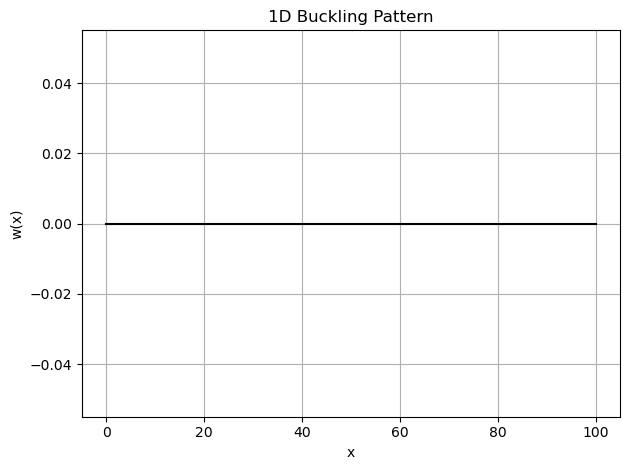

In [5]:
plt.figure()
plt.plot(x, w1d, '-k')
plt.title('1D Buckling Pattern')
plt.xlabel('x')
plt.ylabel('w(x)')
plt.grid(True)
plt.tight_layout()
plt.show()

with $q(x)=0$ everywhere and homogeneous Dirichlet boundary conditions $w(0)=w(L)=0$.  A linear boundary-value problem of the form
$L[w]=0,w(0)=w(L)=0$ always has the trivial solution $w(x)\equiv0$

### 2.2. small perturbation

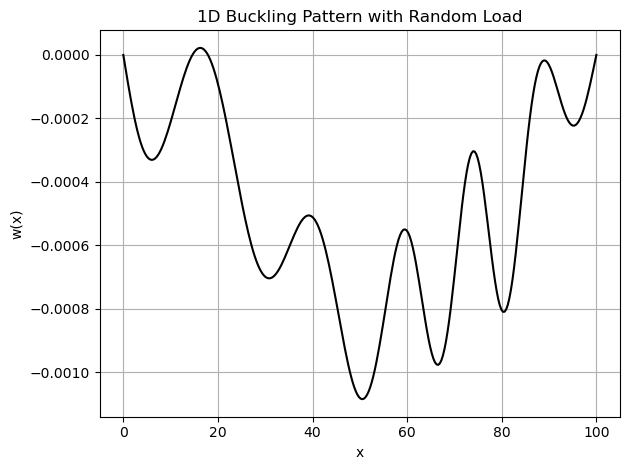

In [6]:
# a tiny spatial load or imperfection
q = 1e-2 * np.random.randn(N)
w1d = model.sim_buckling(E_mean, nu, tc, P, q, x)

plt.figure()
plt.plot(x, w1d, '-k')
plt.title('1D Buckling Pattern with Random Load')
plt.xlabel('x')
plt.ylabel('w(x)')
plt.grid(True)
plt.tight_layout()
plt.show()

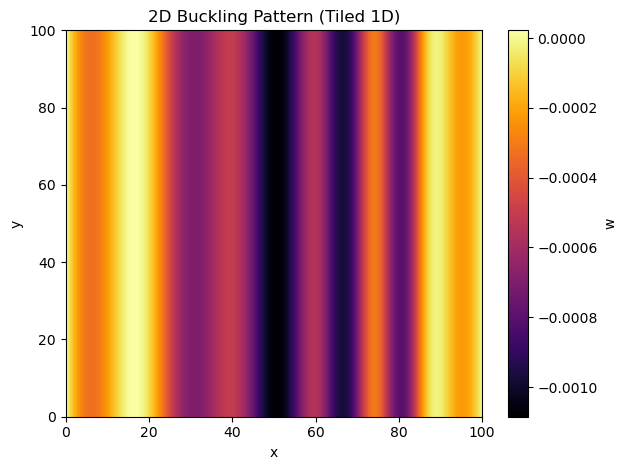

In [7]:
# tile this 1D pattern into a 2D pattern
Ny = 300
y = np.linspace(0, domain_length, Ny)
W2d = np.tile(w1d, (Ny,1))

plt.figure()
plt.imshow(W2d, extent=[0,domain_length,0,domain_length], origin='lower', cmap='inferno', aspect='auto')
plt.title('2D Buckling Pattern (Tiled 1D)')
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar(label='w')
plt.tight_layout()
plt.show()

### 2.3. estimate wavelength

In [8]:
wavelength = model.estimate_wavelength(W2d, dx)
print(f"Estimated dominant wavelength: {wavelength:.2f} units")

Estimated dominant wavelength: 0.48 units


### 2.4. vary $P$

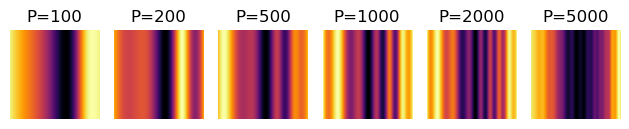

In [9]:
P_values = [100, 200, 500, 1000, 2000, 5000]
fig, axes = plt.subplots(1,6, )
for ax, Pv in zip(axes, P_values):
    Wtmp = np.tile(model.sim_buckling(E_mean, nu, tc, Pv, q, x), (Ny,1))
    ax.imshow(Wtmp, origin='lower', cmap='inferno')
    ax.set_title(f'P={Pv}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3. 2D Simulation

### 3.1. simulation

In [10]:
Lx, Ly = 100.0, 100.0
Nx, Ny = 60, 60
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

tc2d = (
    1.0
    + 0.3 * np.sin(2*np.pi * X / Lx) * np.cos(2*np.pi * Y / Ly)
    + 0.05 * np.random.randn(Ny, Nx)
)

q2d = 0.01 * np.random.randn(Ny, Nx)
w2d = model.sim_buckling_2d(E=1e5, nu=0.35, tc=tc2d, P=1e3, q=q2d, Lx=Lx, Ly=Ly)

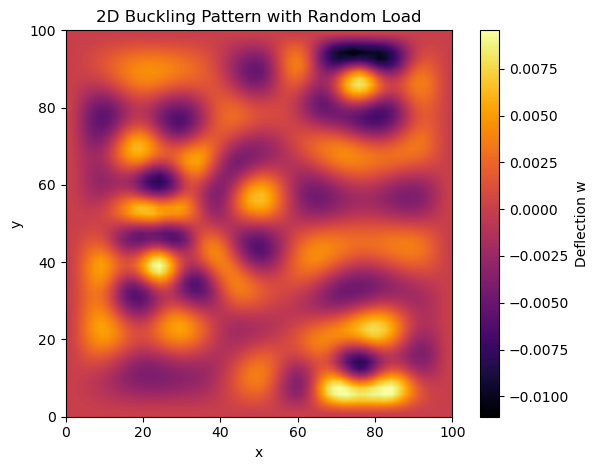

In [11]:
plt.figure()
plt.imshow(w2d,
           extent=[0, Lx, 0, Ly],
           origin='lower',
           aspect='equal',
           cmap='inferno',
           interpolation='bilinear')
plt.colorbar(label='Deflection w')
plt.title('2D Buckling Pattern with Random Load')
plt.xlabel('x'); plt.ylabel('y')
plt.tight_layout()
plt.show()

### 3.2. estimate wavelenths

In [12]:
lamb_radial, lamb_x, lamb_y, (fxp, fyp) = model.estimate_wavelength_2d(W2d, dx)
print(f"λx = {lamb_x:.2f},  λy = {lamb_y:.2f}")

λx = 100.33,  λy = 8.36


### 3.3. vary $P$, $A$, $Q$

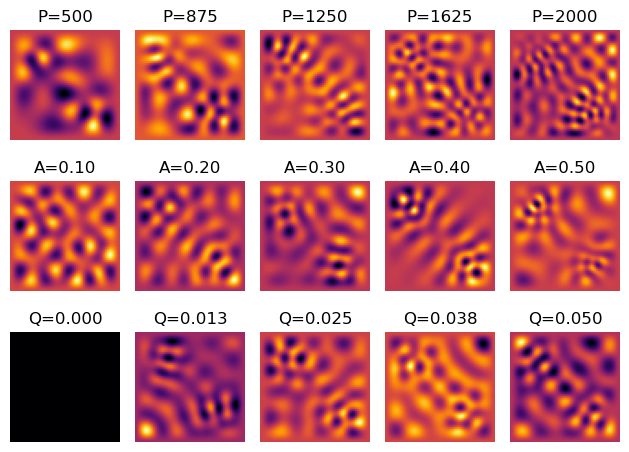

In [13]:
# Parameter grids
P_vals = np.linspace(500, 2000, 5)
A_vals = np.linspace(0.1, 0.5, 5)
Q_vals = np.linspace(0.0, 0.05, 5)

fig, axs = plt.subplots(3, 5, )

for col in range(5):
    # Vary P
    P = P_vals[col]
    A = 0.3
    Q = 0.01
    tc2d = 1.0 + A * np.sin(2*np.pi*X/Lx) * np.sin(2*np.pi*Y/Ly)
    q2d = Q * np.random.randn(Ny, Nx)
    Ny, Nx = tc2d.shape
    q2d = Q * np.random.randn(Ny, Nx)
    w = model.sim_buckling_2d(1e5, 0.35, tc2d, P, q2d, Lx, Ly)
    ax = axs[0, col]
    im = ax.imshow(w, origin='lower', extent=[0,Lx,0,Ly], cmap='inferno')
    ax.set_title(f'P={P:.0f}')
    ax.axis('off')

    # Vary A
    P = 1000
    A = A_vals[col]
    Q = 0.01
    tc2d = 1.0 + A * np.sin(2*np.pi*X/Lx) * np.sin(2*np.pi*Y/Ly)
    q2d = Q * np.random.randn(Ny, Nx)
    w = model.sim_buckling_2d(1e5, 0.35, tc2d, P, q2d, Lx, Ly)
    ax = axs[1, col]
    ax.imshow(w, origin='lower', extent=[0,Lx,0,Ly], cmap='inferno')
    ax.set_title(f'A={A:.2f}')
    ax.axis('off')

    # Vary Q
    P = 1000
    A = 0.3
    Q = Q_vals[col]
    tc2d = 1.0 + A * np.sin(2*np.pi*X/Lx) * np.sin(2*np.pi*Y/Ly)
    q2d = Q * np.random.randn(Ny, Nx)
    w = model.sim_buckling_2d(1e5, 0.35, tc2d, P, q2d, Lx, Ly)
    ax = axs[2, col]
    ax.imshow(w, origin='lower', extent=[0,Lx,0,Ly], cmap='inferno')
    ax.set_title(f'Q={Q:.3f}')
    ax.axis('off')

axs[0,0].set_ylabel('Vary P', size='large')
axs[1,0].set_ylabel('Vary A', size='large')
axs[2,0].set_ylabel('Vary Q', size='large')

plt.tight_layout()
plt.show()